### Libraries

In [134]:
from keras import backend as K
from keras.engine.topology import Layer
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, AveragePooling2D, TimeDistributed, Concatenate, Lambda
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import random
import copy
import pdb
import math
import time
import itertools
import pprint
import sys
from optparse import OptionParser
import pickle
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model
from keras.utils import generic_utils
from keras.callbacks import TensorBoard
from keras.engine import Layer, InputSpec
from keras import initializers, regularizers
from keras.objectives import categorical_crossentropy
import warnings
warnings.filterwarnings('ignore')

In [135]:
%cd /content/drive/MyDrive/models/research/object_detection/images/train

/content/drive/MyDrive/models/research/object_detection/images/train


In [136]:
# Setting the home directory.
%pwd

'/content/drive/MyDrive/models/research/object_detection/images/train'

In [137]:
# Defining the class for the initial configration of the model
class Config:
  def __init__(self):
    self.verbose = True
    # base CNN model
    self.network = 'inception_resnet_v2'
    # setting for data augmentation
    self.use_horizontal_flips = False
    self.use_vertical_flips = False
    self.rot_90 = False
    # anchor box scales
    self.anchor_box_scales = [128, 256, 512]
    # anchor box ratios
    self.anchor_box_ratios = [[1, 1], [1, 2], [2, 1]]
    # size to resize the smallest side of the image
    self.im_size = 600
    self.img_channel_mean = [158.46, 166.39, 135.75]
    self.img_scaling_factor = 1.0
    self.num_rois = 32
    self.rpn_stride = 16
    self.balanced_classes = False
    self.std_scaling = 4.0
    self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]
    self.rpn_min_overlap = 0.3
    self.rpn_max_overlap = 0.7
    self.classifier_min_overlap = 0.1
    self.classifier_max_overlap = 0.5
    self.class_mapping = None
    self.model_path = 'model_frcnn.{}.hdf5'.format(self.network)

In [138]:
# function to map the target variable to the feature varialbes
def get_data(input_path):
  found_bg = False
  all_imgs = {}
  classes_count = {}
  class_mapping = {}
  visualise = True
  df = pd.read_csv(input_path).values
  for line in df:
    (filename, x1, y1, x2, y2, class_name) = line
    if class_name not in classes_count:
      classes_count[class_name] = 1
    else:
      classes_count[class_name] += 1
    if class_name not in class_mapping:
      if class_name == 'bg' and found_bg == False:
        print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
        found_bg = True
      class_mapping[class_name] = len(class_mapping)
    if filename not in all_imgs:
      all_imgs[filename] = {}
      img = cv2.imread(filename)
      (rows,cols) = img.shape[:2]
      all_imgs[filename]['filepath'] = filename
      all_imgs[filename]['width'] = cols
      all_imgs[filename]['height'] = rows
      all_imgs[filename]['bboxes'] = []
    all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})
  all_data = []
  for key in all_imgs:
    all_data.append(all_imgs[key])
  if found_bg:
    if class_mapping['bg'] != len(class_mapping) - 1:
      key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping)-1][0]
      val_to_switch = class_mapping['bg']
      class_mapping['bg'] = len(class_mapping) - 1
      class_mapping[key_to_switch] = val_to_switch
  return all_data, classes_count, class_mapping

In [139]:
# Defining the class to generate the RPN layer
class RoiPoolingConv(Layer):
  def __init__(self, pool_size, num_rois, **kwargs):
    self.dim_ordering = K.image_data_format()
    self.pool_size = pool_size
    self.num_rois = num_rois
    super(RoiPoolingConv, self).__init__(**kwargs)
  def build(self, input_shape):
    self.nb_channels = input_shape[0][3]
  def compute_output_shape(self, input_shape):
    return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels
  def call(self, x, mask=None):
    assert(len(x) == 2)
    img = x[0]
    rois = x[1]
    input_shape = K.shape(img)
    outputs = []
    for roi_idx in range(self.num_rois):
      x = rois[0, roi_idx, 0]
      y = rois[0, roi_idx, 1]
      w = rois[0, roi_idx, 2]
      h = rois[0, roi_idx, 3]
      row_length = w / float(self.pool_size)
      col_length = h / float(self.pool_size)
      num_pool_regions = self.pool_size
      x = K.cast(x, 'int32')
      y = K.cast(y, 'int32')
      w = K.cast(w, 'int32')
      h = K.cast(h, 'int32')
      rs = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
      outputs.append(rs)
    final_output = K.concatenate(outputs, axis=0)
    final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))
    final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))
    return final_output

In [140]:
# Defining a class for Batchnormalization layer for the network
class FixedBatchNormalization(Layer):
  def __init__(self , epsilon = 1e-3, axis = -1, weights = None, beta_init = 'zero', gamma_init = 'one',
               gamma_regularizer = None, beta_regularizer = None, **kwargs):
    self.supports_masking = True
    self.beta_init = initializers.get(beta_init)
    self.gamma_init = initializers.get(gamma_init)
    self.epsilon = epsilon
    self.axis = axis
    self.gamma_regularizer = regularizers.get(gamma_regularizer)
    self.beta_regularizer = regularizers.get(beta_regularizer)
    self.initial_weights = weights
    super(FixedBatchNormalization, self).__init__(**kwargs)

  def build(self, input_shape):
    self.input_spec = [InputSpec(shape=input_shape)]
    shape = (input_shape[self.axis],)
    self.gamma = self.add_weight(shape,initializer=self.gamma_init,
                                 regularizer=self.gamma_regularizer,
                                 name='{}_gamma'.format(self.name),trainable=False)
    self.beta = self.add_weight(shape,initializer=self.beta_init,
                                regularizer=self.beta_regularizer,
                                name='{}_beta'.format(self.name),
                                trainable=False)
    self.running_mean = self.add_weight(shape, initializer='zero',
                                        name='{}_running_mean'.format(self.name),
                                        trainable=False)
    self.running_std = self.add_weight(shape, initializer='one',
                                       name='{}_running_std'.format(self.name),
                                       trainable=False)
    if self.initial_weights is not None:
      self.set_weights(self.initial_weights)
      del self.initial_weights
    self.built = True
  
  def call(self, x, mask = None):
    assert self.built, 'Layer must be built before being called'
    input_shape = K.int_shape(x)
    reduction_axes = list(range(len(input_shape)))
    del reduction_axes[self.axis]
    broadcast_shape = [1] * len(input_shape)
    broadcast_shape[self.axis] = input_shape[self.axis]
    if sorted(reduction_axes) == range(K.ndim(x))[:-1]:
      x_normed = K.batch_normalization(
          x, self.running_mean, self.running_std,
          self.beta, self.gamma,
          epsilon=self.epsilon)
    else:
      broadcast_running_mean = K.reshape(self.running_mean, broadcast_shape)
      broadcast_running_std = K.reshape(self.running_std, broadcast_shape)
      broadcast_beta = K.reshape(self.beta, broadcast_shape)
      broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
      x_normed = K.batch_normalization(
          x, broadcast_running_mean, broadcast_running_std,
          broadcast_beta, broadcast_gamma,
          epsilon=self.epsilon)
    return x_normed

  def get_config(self):
    config = {'epsilon': self.epsilon,
              'axis': self.axis,
              'gamma_regularizer': self.gamma_regularizer.get_config() if self.gamma_regularizer else None,
              'beta_regularizer': self.beta_regularizer.get_config() if self.beta_regularizer else None}
    base_config = super(FixedBatchNormalization, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

In [141]:
def get_img_output_length(width, height):
  def get_output_length(input_length):
    filter_sizes = [3, 3, 3, 3, 3, 3]
    strides = [2, 1, 2, 1, 2, 2]
    assert len(filter_sizes) == len(strides)
    for i in range(len(filter_sizes)):
      input_length = (input_length - filter_sizes[i]) // strides[i] + 1
    return input_length
  return get_output_length(width), get_output_length(height)

def conv2d_bn(x,
              filters,
              kernel_size,
              strides=1,
              padding='same',
              activation='relu',
              use_bias=False,
              name=None):
  x = Conv2D(filters,
             kernel_size,
             strides=strides,
             padding=padding,
             use_bias=use_bias,
             name=name)(x)
  if not use_bias:
    bn_axis = 1 if K.image_data_format() == 'channels_first' else 3
    bn_name = None if name is None else name + '_bn'
    x = BatchNormalization(axis=bn_axis,
                           scale=False,
                           name=bn_name)(x)
  if activation is not None:
    ac_name = None if name is None else name + '_ac'
    x = Activation(activation, name=ac_name)(x)
  return x

def conv2d_bn_td(x,
                 filters,
                 kernel_size,
                 strides = 1,
                 padding = 'same',
                 activation = 'relu',
                 use_bias = False,
                 name = None):
  x = TimeDistributed(Conv2D(filters,
                             kernel_size,
                             strides = strides,
                             padding = padding,
                             use_bias = use_bias),
                      name = name)(x)
  if not use_bias:
    bn_axis = 1 if K.image_data_format() == 'channels_first' else 3
    bn_name = None if name is None else name + '_bn'
    x = TimeDistributed(BatchNormalization(axis=bn_axis,
                                           scale=False),
                        name=bn_name)(x)
  if activation is not None:
    ac_name = None if name is None else name + '_ac'
    x = Activation(activation, name=ac_name)(x)
  return x

def inception_resnet_block(x, scale, block_type, block_idx, activation='relu'):
  block_name = block_type + '_' + str(block_idx)
  if block_type == 'block35':
    branch_0 = conv2d_bn(x, 32, 1, name=block_name + '_conv1')
    branch_1 = conv2d_bn(x, 32, 1, name=block_name + '_conv2')
    branch_1 = conv2d_bn(branch_1, 32, 3, name=block_name + '_conv3')
    branch_2 = conv2d_bn(x, 32, 1, name=block_name + '_conv4')
    branch_2 = conv2d_bn(branch_2, 48, 3, name=block_name + '_conv5')
    branch_2 = conv2d_bn(branch_2, 64, 3, name=block_name + '_conv6')
    branches = [branch_0, branch_1, branch_2]
  elif block_type == 'block17':
    branch_0 = conv2d_bn(x, 192, 1, name=block_name + '_conv1')
    branch_1 = conv2d_bn(x, 128, 1, name=block_name + '_conv2')
    branch_1 = conv2d_bn(branch_1, 160, [1, 7], name=block_name + '_conv3')
    branch_1 = conv2d_bn(branch_1, 192, [7, 1], name=block_name + '_conv4')
    branches = [branch_0, branch_1]
  elif block_type == 'block8':
    branch_0 = conv2d_bn(x, 192, 1, name=block_name + '_conv1')
    branch_1 = conv2d_bn(x, 192, 1, name=block_name + '_conv2')
    branch_1 = conv2d_bn(branch_1, 224, [1, 3], name=block_name + '_conv3')
    branch_1 = conv2d_bn(branch_1, 256, [3, 1], name=block_name + '_conv4')
    branches = [branch_0, branch_1]
  else:
    raise ValueError('Unknown Inception-ResNet block type. '
                         'Expects "block35", "block17" or "block8", '
                         'but got: ' + str(block_type))
  channel_axis = 1 if K.image_data_format() == 'channels_first' else 3
  mixed = Concatenate(axis=channel_axis, name=block_name + '_mixed')(branches)
  up = conv2d_bn(mixed,
                 K.int_shape(x)[channel_axis],
                 1,
                 activation=None,
                 use_bias=True,
                 name=block_name + '_conv')
  x = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
             output_shape=K.int_shape(x)[1:],
             arguments={'scale': scale},
             name=block_name)([x, up]) 
  if activation is not None:
    x = Activation(activation, name=block_name + '_ac')(x)
  return x

def inception_resnet_block_td(x, scale, block_type, block_idx, activation='relu'):
  block_name = block_type + '_' + str(block_idx)
  if block_type == 'block35':
    branch_0 = conv2d_bn_td(x, 32, 1, name=block_name + '_conv1')
    branch_1 = conv2d_bn_td(x, 32, 1, name=block_name + '_conv2')
    branch_1 = conv2d_bn_td(branch_1, 32, 3, name=block_name + '_conv3')
    branch_2 = conv2d_bn_td(x, 32, 1, name=block_name + '_conv4')
    branch_2 = conv2d_bn_td(branch_2, 48, 3, name=block_name + '_conv5')
    branch_2 = conv2d_bn_td(branch_2, 64, 3, name=block_name + '_conv6')
    branches = [branch_0, branch_1, branch_2]
  elif block_type == 'block17':
    branch_0 = conv2d_bn_td(x, 192, 1, name=block_name + '_conv1')
    branch_1 = conv2d_bn_td(x, 128, 1, name=block_name + '_conv2')
    branch_1 = conv2d_bn_td(branch_1, 160, [1, 7], name=block_name + '_conv3')
    branch_1 = conv2d_bn_td(branch_1, 192, [7, 1], name=block_name + '_conv4')
    branches = [branch_0, branch_1]
  elif block_type == 'block8':
    branch_0 = conv2d_bn_td(x, 192, 1, name=block_name + '_conv1')
    branch_1 = conv2d_bn_td(x, 192, 1, name=block_name + '_conv2')
    branch_1 = conv2d_bn_td(branch_1, 224, [1, 3], name=block_name + '_conv3')
    branch_1 = conv2d_bn_td(branch_1, 256, [3, 1], name=block_name + '_conv4')
    branches = [branch_0, branch_1]
  else:
    raise ValueError('Unknown Inception-ResNet block type. '
                         'Expects "block35", "block17" or "block8", '
                         'but got: ' + str(block_type))
  channel_axis = 1 if K.image_data_format() == 'channels_first' else 4
  mixed = Concatenate(axis=channel_axis, name=block_name + '_mixed')(branches)
  up = conv2d_bn_td(mixed,
                    K.int_shape(x)[channel_axis],
                    1,
                    activation=None,
                    use_bias=True,
                    name=block_name + '_conv')
  x = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
             output_shape=K.int_shape(x)[1:],
             arguments={'scale': scale},
             name=block_name)([x, up])
  if activation is not None:
    x = Activation(activation, name=block_name + '_ac')(x)
  return x

def nn_base(input_tensor=None, trainable=False):
  input_shape = (None, None, 3)
  if input_tensor is None:
    img_input = Input(shape=input_shape)
  else:
    if not K.is_keras_tensor(input_tensor):
      img_input = Input(tensor=input_tensor, shape=input_shape)
    else:
      img_input = input_tensor
  bn_axis = 3
  x = conv2d_bn(img_input, 32, 3, strides=2, padding='valid', name='Stem_block' + '_conv1')
  x = conv2d_bn(x, 32, 3, padding='valid', name='Stem_block' + '_conv2')
  x = conv2d_bn(x, 64, 3, name='Stem_block' + '_conv3')
  x = MaxPooling2D(3, strides=2)(x)
  x = conv2d_bn(x, 80, 1, padding='valid', name='Stem_block' + '_conv4')
  x = conv2d_bn(x, 192, 3, padding='valid', name='Stem_block' + '_conv5')
  x = MaxPooling2D(3, strides=2)(x)

  branch_0 = conv2d_bn(x, 96, 1, name='Inception_A_block' + '_conv1')
  branch_1 = conv2d_bn(x, 48, 1, name='Inception_A_block' + '_conv2')
  branch_1 = conv2d_bn(branch_1, 64, 5, name='Inception_A_block' + '_conv3')
  branch_2 = conv2d_bn(x, 64, 1, name='Inception_A_block' + '_conv4')
  branch_2 = conv2d_bn(branch_2, 96, 3, name='Inception_A_block' + '_conv5')
  branch_2 = conv2d_bn(branch_2, 96, 3, name='Inception_A_block' + '_conv6')
  branch_pool = AveragePooling2D(3, strides=1, padding='same')(x)
  branch_pool = conv2d_bn(branch_pool, 64, 1, name='Inception_A_block' + '_conv7')
  branches = [branch_0, branch_1, branch_2, branch_pool]
  channel_axis = 1 if K.image_data_format() == 'channels_first' else 3
  x = Concatenate(axis=channel_axis, name='mixed_5b')(branches)
  for block_idx in range(1, 11):
    x = inception_resnet_block(x,
                               scale=0.17,
                               block_type='block35',
                               block_idx=block_idx)
  branch_0 = conv2d_bn(x, 384, 3, strides=2, padding='valid', name='Reduction_A_block' + '_conv1')
  branch_1 = conv2d_bn(x, 256, 1, name='Reduction_A_block' + '_conv2')
  branch_1 = conv2d_bn(branch_1, 256, 3, name='Reduction_A_block' + '_conv3')
  branch_1 = conv2d_bn(branch_1, 384, 3, strides=2, padding='valid', name='Reduction_A_block' + '_conv4')
  branch_pool = MaxPooling2D(3, strides=2, padding='valid')(x)
  branches = [branch_0, branch_1, branch_pool]
  x = Concatenate(axis=channel_axis, name='mixed_6a')(branches)
  for block_idx in range(1, 21):
    x = inception_resnet_block(x,
                               scale=0.1,
                               block_type='block17',
                               block_idx=block_idx)
  return x

def classifier_layers(x, input_shape, trainable=False):
  channel_axis = 1 if K.image_data_format() == 'channels_first' else 4
  branch_0 = conv2d_bn_td(x, 256, 1, name='Reduction_B_block' + '_conv1')
  branch_0 = conv2d_bn_td(branch_0, 384, 3, strides=2, padding='valid', name='Reduction_B_block' + '_conv2')
  branch_1 = conv2d_bn_td(x, 256, 1, name='Reduction_B_block' + '_conv3')
  branch_1 = conv2d_bn_td(branch_1, 288, 3, strides=2, padding='valid', name='Reduction_B_block' + '_conv4')
  branch_2 = conv2d_bn_td(x, 256, 1, name='Reduction_B_block' + '_conv5')
  branch_2 = conv2d_bn_td(branch_2, 288, 3, name='Reduction_B_block' + '_conv6')
  branch_2 = conv2d_bn_td(branch_2, 320, 3, strides=2, padding='valid', name='Reduction_B_block' + '_conv7')
  branch_pool = TimeDistributed(MaxPooling2D(3, strides=2, padding='valid'))(x)
  branches = [branch_0, branch_1, branch_2, branch_pool]
  x = Concatenate(axis=channel_axis, name='mixed_7a')(branches)
  for block_idx in range(1, 10):
    x = inception_resnet_block_td(x,
                                  scale=0.2,
                                  block_type='block8',
                                  block_idx=block_idx)
  x = inception_resnet_block_td(x,
                                  scale=1.,
                                  activation=None,
                                  block_type='block8',
                                  block_idx=10)
  x = conv2d_bn_td(x, 1536, 1, name='conv_7b')
  TimeDistributed(GlobalAveragePooling2D(), name='avg_pool')(x)
  return x

def rpn(base_layers, num_anchors):
  x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)
  x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
  x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)
  return [x_class, x_regr, base_layers]

def classifier(base_layers, input_rois, num_rois, nb_classes=2, trainable=False):
  pooling_regions = 7
  input_shape = (num_rois, 7, 7, 1088)
  out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])
  out = classifier_layers(out_roi_pool, input_shape=input_shape, trainable=True)
  out = TimeDistributed(Flatten())(out)
  out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
  out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)
  return [out_class, out_regr]

In [142]:
def union(au, bu, area_intersection):
  area_a = (au[2] - au[0]) * (au[3] - au[1])
  area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
  area_union = area_a + area_b - area_intersection
  return area_union

def intersection(ai, bi):
  x = max(ai[0], bi[0])
  y = max(ai[1], bi[1])
  w = min(ai[2], bi[2]) - x
  h = min(ai[3], bi[3]) - y
  if w < 0 or h < 0:
    return 0
  return w*h

def iou(a, b):
  # a and b should be (x1,y1,x2,y2)
  if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
    return 0.0
  area_i = intersection(a, b)
  area_u = union(a, b, area_i)
  return float(area_i) / float(area_u + 1e-6)

def get_new_img_size(width, height, img_min_size=300):
  if width <= height:
    f = float(img_min_size) / width
    resized_height = int(f * height)
    resized_width = int(img_min_size)
  else:
    f = float(img_min_size) / height
    resized_width = int(f * width)
    resized_height = int(img_min_size)

  return resized_width, resized_height

In [143]:
def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):
  downscale = float(C.rpn_stride)
  anchor_sizes = C.anchor_box_scales
  anchor_ratios = C.anchor_box_ratios
  num_anchors = len(anchor_sizes) * len(anchor_ratios)
  (output_width, output_height) = img_length_calc_function(resized_width, resized_height)
  n_anchratios = len(anchor_ratios)
  y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
  y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
  y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))
  num_bboxes = len(img_data['bboxes'])
  num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
  best_anchor_for_bbox = -1 * np.ones((num_bboxes, 4)).astype(int)
  best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
  best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
  best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)
  gta = np.zeros((num_bboxes, 4))
  
  for bbox_num, bbox in enumerate(img_data['bboxes']):
    gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
    gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
    gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
    gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))
  
  for anchor_size_idx in range(len(anchor_sizes)):
    for anchor_ratio_idx in range(n_anchratios):
      anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
      anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]
      for ix in range(output_width):
        x1_anc = downscale * (ix + 0.5) - anchor_x / 2
        x2_anc = downscale * (ix + 0.5) + anchor_x / 2
        if x1_anc < 0 or x2_anc > resized_width:
          continue
        for jy in range(output_height):
          y1_anc = downscale * (jy + 0.5) - anchor_y / 2
          y2_anc = downscale * (jy + 0.5) + anchor_y / 2
          if y1_anc < 0 or y2_anc > resized_height:
            continue
          bbox_type = 'neg'
          best_iou_for_loc = 0.0
          for bbox_num in range(num_bboxes):
            curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
            if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > C.rpn_max_overlap:
              cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
              cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
              cxa = (x1_anc + x2_anc)/2.0
              cya = (y1_anc + y2_anc)/2.0
              tx = (cx - cxa) / (x2_anc - x1_anc)
              ty = (cy - cya) / (y2_anc - y1_anc)
              tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
              th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))
            if img_data['bboxes'][bbox_num]['class'] != 'bg':
              if curr_iou > best_iou_for_bbox[bbox_num]:
                best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
                best_iou_for_bbox[bbox_num] = curr_iou
                best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
                best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]
              if curr_iou > C.rpn_max_overlap:
                bbox_type = 'pos'
                num_anchors_for_bbox[bbox_num] += 1
                if curr_iou > best_iou_for_loc:
                  best_iou_for_loc = curr_iou
                  best_regr = (tx, ty, tw, th)
              if C.rpn_min_overlap < curr_iou < C.rpn_max_overlap:
                if bbox_type != 'pos':
                  bbox_type = 'neutral'
          if bbox_type == 'neg':
            y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
            y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
          elif bbox_type == 'neutral':
            y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
            y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
          elif bbox_type == 'pos':
            y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
            y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
            start = 4 * (anchor_ratio_idx + n_anchratios * anchor_size_idx)
            y_rpn_regr[jy, ix, start:start+4] = best_regr
  for idx in range(num_anchors_for_bbox.shape[0]):
    if num_anchors_for_bbox[idx] == 0:
      if best_anchor_for_bbox[idx, 0] == -1:
        continue
      y_is_box_valid[
                     best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
                     best_anchor_for_bbox[idx,3]] = 1
      y_rpn_overlap[
                    best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
                    best_anchor_for_bbox[idx,3]] = 1
      start = 4 * (best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3])
      y_rpn_regr[best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]
  
  y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
  y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)
  y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
  y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)
  y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
  y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)
  pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
  neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))
  num_pos = len(pos_locs[0])
  num_regions = 256
  if len(pos_locs[0]) > num_regions/2:
    val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
    y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
    num_pos = num_regions/2
  if len(neg_locs[0]) + num_pos > num_regions:
    val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
    y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0
  
  y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
  y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

  return np.copy(y_rpn_cls), np.copy(y_rpn_regr)

In [144]:
def augment(img_data, config, augment=True):
  assert 'filepath' in img_data
  assert 'bboxes' in img_data
  assert 'width' in img_data
  assert 'height' in img_data
  img_data_aug = copy.deepcopy(img_data)
  img = cv2.imread(img_data_aug['filepath'])
  if augment:
    rows, cols = img.shape[:2]
    if config.use_horizontal_flips and np.random.randint(0, 2) == 0:
      img = cv2.flip(img, 1)
      for bbox in img_data_aug['bboxes']:
          x1 = bbox['x1']
          x2 = bbox['x2']
          bbox['x2'] = cols - x1
          bbox['x1'] = cols - x2
    if config.rot_90:
      angle = np.random.choice([0,90,180,270],1)[0]
      if angle == 270:
        img = np.transpose(img, (1,0,2))
        img = cv2.flip(img, 0)
      elif angle == 180:
        img = cv2.flip(img, -1)
      elif angle == 90:
        img = np.transpose(img, (1,0,2))
        img = cv2.flip(img, 1)
      elif angle == 0:
        pass
      for bbox in img_data_aug['bboxes']:
        x1 = bbox['x1']
        x2 = bbox['x2']
        y1 = bbox['y1']
        y2 = bbox['y2']
        if angle == 270:
          bbox['x1'] = y1
          bbox['x2'] = y2
          bbox['y1'] = cols - x2
          bbox['y2'] = cols - x1
        elif angle == 180:
          bbox['x2'] = cols - x1
          bbox['x1'] = cols - x2
          bbox['y2'] = rows - y1
          bbox['y1'] = rows - y2
        elif angle == 90:
          bbox['x1'] = rows - y2
          bbox['x2'] = rows - y1
          bbox['y1'] = x1
          bbox['y2'] = x2
        elif angle == 0:
          pass
  img_data_aug['width'] = img.shape[1]
  img_data_aug['height'] = img.shape[0]
  return img_data_aug, img

In [145]:
def get_anchor_gt(all_img_data, class_count, C, img_length_calc_function, backend, mode='train'):
  while True:
    if mode == 'train':
      random.shuffle(all_img_data)
    for img_data in all_img_data:
      if mode == 'train':
        img_data_aug, x_img = augment(img_data, C, augment=False)
      else:
        img_data_aug, x_img = augment(img_data, C, augment=True)
      (width, height) = (img_data_aug['width'], img_data_aug['height'])
      (rows, cols, _) = x_img.shape
      assert cols == width
      assert rows == height
      (resized_width, resized_height) = get_new_img_size(width, height, C.im_size)
      x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
      try:
        y_rpn_cls, y_rpn_regr = calc_rpn(C, img_data_aug, width, height, resized_width, resized_height, img_length_calc_function)
      except:
        continue
      x_img = x_img[:, :, (2, 1, 0)]
      x_img = x_img.astype(np.float32)
      x_img[:, :, 0] -= C.img_channel_mean[0]
      x_img[:, :, 1] -= C.img_channel_mean[1]
      x_img[:, :, 2] -= C.img_channel_mean[2]
      x_img /= C.img_scaling_factor
      x_img = np.transpose(x_img, (2, 0, 1))
      x_img = np.expand_dims(x_img, axis=0)
      y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= C.std_scaling
      x_img = np.transpose(x_img, (0, 2, 3, 1))
      y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
      y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))
      yield np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug

In [146]:
lambda_rpn_regr = 1.0
lambda_rpn_class = 1.0
lambda_cls_regr = 1.0
lambda_cls_class = 1.0
epsilon = 1e-4

In [147]:
def rpn_loss_regr(num_anchors):
  def rpn_loss_regr_fixed_num(y_true, y_pred):
    x = y_true[:, :, :, 4 * num_anchors:] - y_pred
    x_abs = K.abs(x)
    x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)
    return lambda_rpn_regr * K.sum(
        y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])
  return rpn_loss_regr_fixed_num


In [148]:
def rpn_loss_cls(num_anchors):
  def rpn_loss_cls_fixed_num(y_true, y_pred):
    return lambda_rpn_class * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])
  return rpn_loss_cls_fixed_num

In [149]:
def class_loss_regr(num_classes):
  def class_loss_regr_fixed_num(y_true, y_pred):
    x = y_true[:, :, 4*num_classes:] - y_pred
    x_abs = K.abs(x)
    x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
    return lambda_cls_regr * K.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :4*num_classes])
  return class_loss_regr_fixed_num

In [150]:
def class_loss_cls(y_true, y_pred):
  return lambda_cls_class * K.mean(categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))

In [151]:
def calc_iou(R, img_data, C, class_mapping):
  bboxes = img_data['bboxes']
  (width, height) = (img_data['width'], img_data['height'])
  # get image dimensions for resizing
  (resized_width, resized_height) = get_new_img_size(width, height, C.im_size)
  gta = np.zeros((len(bboxes), 4))

  for bbox_num, bbox in enumerate(bboxes):
    # get the GT box coordinates, and resize to account for image resizing
    gta[bbox_num, 0] = int(round(bbox['x1'] * (resized_width / float(width))/C.rpn_stride))
    gta[bbox_num, 1] = int(round(bbox['x2'] * (resized_width / float(width))/C.rpn_stride))
    gta[bbox_num, 2] = int(round(bbox['y1'] * (resized_height / float(height))/C.rpn_stride))
    gta[bbox_num, 3] = int(round(bbox['y2'] * (resized_height / float(height))/C.rpn_stride))
  x_roi = []
  y_class_num = []
  y_class_regr_coords = []
  y_class_regr_label = []
  IoUs = [] # for debugging only
  for ix in range(R.shape[0]):
    (x1, y1, x2, y2) = R[ix, :]
    x1 = int(round(x1))
    y1 = int(round(y1))
    x2 = int(round(x2))
    y2 = int(round(y2))
    best_iou = 0.0
    best_bbox = -1
    for bbox_num in range(len(bboxes)):
      curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1, y1, x2, y2])
      if curr_iou > best_iou:
        best_iou = curr_iou
        best_bbox = bbox_num
    if best_iou < C.classifier_min_overlap:
      continue
    else:
      w = x2 - x1
      h = y2 - y1
      x_roi.append([x1, y1, w, h])
      IoUs.append(best_iou)
      if C.classifier_min_overlap <= best_iou < C.classifier_max_overlap:
        # hard negative example
        cls_name = 'bg'
      elif C.classifier_max_overlap <= best_iou:
        cls_name = bboxes[best_bbox]['class']
        cxg = (gta[best_bbox, 0] + gta[best_bbox, 1]) / 2.0
        cyg = (gta[best_bbox, 2] + gta[best_bbox, 3]) / 2.0
        cx = x1 + w / 2.0
        cy = y1 + h / 2.0
        tx = (cxg - cx) / float(w)
        ty = (cyg - cy) / float(h)
        tw = np.log((gta[best_bbox, 1] - gta[best_bbox, 0]) / float(w))
        th = np.log((gta[best_bbox, 3] - gta[best_bbox, 2]) / float(h))
      else:
        print('roi = {}'.format(best_iou))
        raise RuntimeError
    class_num = class_mapping[cls_name]
    class_label = len(class_mapping) * [0]
    class_label[class_num] = 1
    y_class_num.append(copy.deepcopy(class_label))
    coords = [0] * 4 * (len(class_mapping) - 1)
    labels = [0] * 4 * (len(class_mapping) - 1)
    if cls_name != 'bg':
      label_pos = 4 * class_num
      sx, sy, sw, sh = C.classifier_regr_std
      coords[label_pos:4+label_pos] = [sx*tx, sy*ty, sw*tw, sh*th]
      labels[label_pos:4+label_pos] = [1, 1, 1, 1]
      y_class_regr_coords.append(copy.deepcopy(coords))
      y_class_regr_label.append(copy.deepcopy(labels))
    else:
      y_class_regr_coords.append(copy.deepcopy(coords))
      y_class_regr_label.append(copy.deepcopy(labels))

  if len(x_roi) == 0:
    return None, None, None, None 
  X = np.array(x_roi,dtype = np.float32)
  Y1 = np.array(y_class_num,dtype = np.float32)
  Y2 = np.concatenate([np.array(y_class_regr_label, dtype = np.float32),np.array(y_class_regr_coords, np.float32)],axis=1)

  return np.expand_dims(X, axis=0), np.expand_dims(Y1, axis=0), np.expand_dims(Y2, axis=0), IoUs


def apply_regr(x, y, w, h, tx, ty, tw, th):
  try:
    cx = x + w/2.
    cy = y + h/2.
    cx1 = tx * w + cx
    cy1 = ty * h + cy
    w1 = math.exp(tw) * w
    h1 = math.exp(th) * h
    x1 = cx1 - w1/2.
    y1 = cy1 - h1/2.
    x1 = round(x1)
    y1 = round(y1)
    w1 = round(w1)
    h1 = round(h1)
    return x1, y1, w1, h1
  except ValueError:
    return x, y, w, h
  except OverflowError:
    return x, y, w, h
  except Exception as e:
    print(e)
    return x, y, w, h

def apply_regr_np(X, T):
  try:
    x = X[0, :, :]
    y = X[1, :, :]
    w = X[2, :, :]
    h = X[3, :, :]

    tx = T[0, :, :]
    ty = T[1, :, :]
    tw = T[2, :, :]
    th = T[3, :, :]

    cx = x + w/2.
    cy = y + h/2.
    cx1 = tx * w + cx
    cy1 = ty * h + cy

    w1 = np.exp(tw.astype(np.float64)) * w
    h1 = np.exp(th.astype(np.float64)) * h
    x1 = cx1 - w1/2.
    y1 = cy1 - h1/2.

    x1 = np.round(x1)
    y1 = np.round(y1)
    w1 = np.round(w1)
    h1 = np.round(h1)
    return np.stack([x1, y1, w1, h1])
  except Exception as e:
    print(e)
    return X

def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
# code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
# if there are no boxes, return an empty list
  if len(boxes) == 0:
    return []

# grab the coordinates of the bounding boxes
  x1 = boxes[:, 0]
  y1 = boxes[:, 1]
  x2 = boxes[:, 2]
  y2 = boxes[:, 3]

  np.testing.assert_array_less(x1, x2)
  np.testing.assert_array_less(y1, y2)

  # if the bounding boxes integers, convert them to floats --
  # this is important since we'll be doing a bunch of divisions
  if boxes.dtype.kind == "i":
    boxes = boxes.astype("float")

  # initialize the list of picked indexes
  pick = []

  # calculate the areas
  area = (x2 - x1) * (y2 - y1)

  # sort the bounding boxes
  idxs = np.argsort(probs)

# keep looping while some indexes still remain in the indexes
# list
  while len(idxs) > 0:
    # grab the last index in the indexes list and add the
    # index value to the list of picked indexes
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)

    # find the intersection

    xx1_int = np.maximum(x1[i], x1[idxs[:last]])
    yy1_int = np.maximum(y1[i], y1[idxs[:last]])
    xx2_int = np.minimum(x2[i], x2[idxs[:last]])
    yy2_int = np.minimum(y2[i], y2[idxs[:last]])

    ww_int = np.maximum(0, xx2_int - xx1_int)
    hh_int = np.maximum(0, yy2_int - yy1_int)

    area_int = ww_int * hh_int

    # find the union
    area_union = area[i] + area[idxs[:last]] - area_int

    # compute the ratio of overlap
    overlap = area_int/(area_union + 1e-6)

    # delete all indexes from the index list that have
    idxs = np.delete(idxs, np.concatenate(([last],
        np.where(overlap > overlap_thresh)[0])))

    if len(pick) >= max_boxes:
      break

  # return only the bounding boxes that were picked using the integer data type
  boxes = boxes[pick].astype("int")
  probs = probs[pick]
  return boxes, probs


def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.9):
  regr_layer = regr_layer / C.std_scaling
  anchor_sizes = C.anchor_box_scales
  anchor_ratios = C.anchor_box_ratios
  assert rpn_layer.shape[0] == 1
  (rows, cols) = rpn_layer.shape[1:3]
  curr_layer = 0
  A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))
  

  for anchor_size in anchor_sizes:
    for anchor_ratio in anchor_ratios:
      anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
      anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride
      regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4]
      regr = np.transpose(regr, (2, 0, 1))
      X, Y = np.meshgrid(np.arange(cols),np. arange(rows))
      A[0, :, :, curr_layer] = X - anchor_x/2
      A[1, :, :, curr_layer] = Y - anchor_y/2
      A[2, :, :, curr_layer] = anchor_x
      A[3, :, :, curr_layer] = anchor_y
      if use_regr:
        A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)
        A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
        A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])
        A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
        A[3, :, :, curr_layer] += A[1, :, :, curr_layer]
        A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
        A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
        A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
        A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])
        curr_layer += 1
  all_boxes = np.reshape(A.transpose((0, 3, 1,2)), (4, -1)).transpose((1, 0))
  all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))
  x1 = all_boxes[:, 0]
  y1 = all_boxes[:, 1]
  x2 = all_boxes[:, 2]
  y2 = all_boxes[:, 3]
  idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))
  all_boxes = np.delete(all_boxes, idxs, 0)
  all_probs = np.delete(all_probs, idxs, 0)
  result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]
  return result

In [152]:
def write_log(callback, names, logs, batch_no):
  for name, value in zip(names, logs):
    summary = tf.summary
    summary_value = summary.value.add()
    summary_value.simple_value = value
    summary_value.tag = name
    callback.writer.add_summary(summary, batch_no)
    callback.writer.flush()

In [153]:
base_path = '/content/drive/MyDrive/models/research/object_detection/images'
train_path = '/content/drive/MyDrive/models/research/object_detection/images/bbox_train.csv'
num_rois = 32
horizontal_flips = False
vertical_flips = False
rot_90 = False

output_weight_path = os.path.join(base_path, 'model_frcnn.hdf5')
record_path = os.path.join(base_path, 'record.csv')
base_weight_path = os.path.join(base_path, 'resnet50_weights_th_dim_ordering_th_kernels_notop.h5')
config_output_filename = os.path.join(base_path, 'model_config.pickle')

In [154]:
C = Config()
C.use_horizontal_flips = horizontal_flips
C.use_vertical_flips = vertical_flips
C.rot_90 = rot_90

C.record_path = record_path
C.model_path = output_weight_path
C.num_rois = num_rois

C.base_net_weights = base_weight_path

In [155]:
st = time.time()
all_imgs, classes_count, class_mapping = get_data(train_path)
print()
print('Spend %0.2f mins to load the data' % ((time.time()-st)/60) )


Spend 0.51 mins to load the data


In [156]:
if 'bg' not in classes_count:
  classes_count['bg'] = 0
  class_mapping['bg'] = len(class_mapping)
C.class_mapping = class_mapping
inv_map = {v: k for k, v in class_mapping.items()}
print('Training images per class:')
pprint.pprint(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))
with open(config_output_filename, 'wb') as config_f:
	pickle.dump(C,config_f)
	print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(config_output_filename))

Training images per class:
{'bg': 0, 'face': 17207}
Num classes (including bg) = 2
Config has been written to /content/drive/MyDrive/models/research/object_detection/images/model_config.pickle, and can be loaded when testing to ensure correct results


In [157]:
random.seed(1)
random.shuffle(all_imgs)
print('Num train samples (images) {}'.format(len(all_imgs)))

Num train samples (images) 4014


In [158]:
data_gen_train = get_anchor_gt(all_imgs, classes_count, C, get_img_output_length, K.image_data_format(), mode='train')

In [159]:
X, y, image_data = next(data_gen_train)

In [160]:
print('Original image: height=%d width=%d'%(image_data['height'], image_data['width']))
print('Resized image:  height=%d width=%d C.im_size=%d'%(X.shape[1], X.shape[2], C.im_size))
print('Feature map size: height=%d width=%d C.rpn_stride=%d'%(y[0].shape[1], y[0].shape[2], C.rpn_stride))
print(X.shape)
print(str(len(y))+" includes 'y_rpn_cls' and 'y_rpn_regr'")
print('Shape of y_rpn_cls {}'.format(y[0].shape))
print('Shape of y_rpn_regr {}'.format(y[1].shape))
print(image_data)

Original image: height=408 width=612
Resized image:  height=600 width=900 C.im_size=600
Feature map size: height=35 width=54 C.rpn_stride=16
(1, 600, 900, 3)
2 includes 'y_rpn_cls' and 'y_rpn_regr'
Shape of y_rpn_cls (1, 35, 54, 18)
Shape of y_rpn_regr (1, 35, 54, 72)
{'filepath': '16062.jpg', 'width': 612, 'height': 408, 'bboxes': [{'class': 'face', 'x1': 168, 'x2': 306, 'y1': 86, 'y2': 221}, {'class': 'face', 'x1': 331, 'x2': 458, 'y1': 88, 'y2': 228}]}


In [161]:
input_shape_img = (None, None, 3)
img_input = Input(shape = input_shape_img)
roi_input = Input(shape = (None, 4))
shared_layers = nn_base(img_input, trainable=True)

In [162]:
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_ = rpn(shared_layers, num_anchors)
classifier_ = classifier(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count), trainable = True)
model_rpn = Model(img_input, rpn_[:2])
model_classifier = Model([img_input, roi_input], classifier_)
model_all = Model([img_input, roi_input], rpn_[:2] + classifier_)

In [163]:
try:
  print('loading weights from {}'.format(C.base_net_weights))
  model_rpn.load_weights(C.base_net_weights, by_name=True)
  model_classifier.load_weights(C.base_net_weights, by_name=True)
except:
  print('Could not load pretrained model weights. Weights can be found in the keras application folder \
        https://github.com/fchollet/keras/tree/master/keras/applications')

loading weights from /content/drive/MyDrive/models/research/object_detection/images/resnet50_weights_th_dim_ordering_th_kernels_notop.h5


In [164]:
optimizer = Adam(lr=1e-5)
optimizer_classifier = Adam(lr=1e-5)
model_rpn.compile(optimizer=optimizer, loss=[rpn_loss_cls(num_anchors), rpn_loss_regr(num_anchors)])
model_classifier.compile(optimizer=optimizer_classifier, loss=[class_loss_cls, class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
model_all.compile(optimizer='sgd', loss='mae')

In [165]:
log_path = '/content/drive/MyDrive/models/research/object_detection/images/logs'
if not os.path.isdir(log_path):
  os.mkdir(log_path)
callback = TensorBoard(log_path)
callback.set_model(model_all)

In [166]:
epoch_length = 250
num_epochs = 15
iter_num = 0
train_step = 0

losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []
start_time = time.time()

best_loss = np.Inf

class_mapping_inv = {v: k for k, v in class_mapping.items()}

In [ ]:
print('Starting training')
for epoch_num in range(num_epochs):
  progbar = generic_utils.Progbar(epoch_length)
  print('Epoch {}/{}'.format(epoch_num + 1, num_epochs))
  while True:
    if len(rpn_accuracy_rpn_monitor) == epoch_length and C.verbose:
      mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
      rpn_accuracy_rpn_monitor = []
      print('Average number of overlapping bounding boxes from RPN = {} for {} previous iterations'.format(mean_overlapping_bboxes, epoch_length))
      if mean_overlapping_bboxes == 0:
        print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')
    X, Y, img_data = next(data_gen_train)
    loss_rpn = model_rpn.train_on_batch(X,Y)
    #write_log(callback, ['rpn_cls_loss', 'rpn_reg_loss'], loss_rpn, train_step)
    P_rpn = model_rpn.predict_on_batch(X)
    R = rpn_to_roi(P_rpn[0], P_rpn[1], C, K.image_data_format(), use_regr=True, overlap_thresh=0.7, max_boxes=300)
    X2, Y1, Y2, IouS = calc_iou(R, img_data, C, class_mapping)
    if X2 is None:
      rpn_accuracy_rpn_monitor.append(0)
      rpn_accuracy_for_epoch.append(0)
      continue
    neg_samples = np.where(Y1[0, :, -1] == 1)
    pos_samples = np.where(Y1[0, :, -1] == 0)
    if len(neg_samples) > 0:
      neg_samples = neg_samples[0]
    else:
      neg_samples = []

    if len(pos_samples) > 0:
      pos_samples = pos_samples[0]
    else:
      pos_samples = []

    rpn_accuracy_rpn_monitor.append(len(pos_samples))
    rpn_accuracy_for_epoch.append((len(pos_samples)))
    if C.num_rois > 1:
      if len(pos_samples) < C.num_rois//2:
        selected_pos_samples = pos_samples.tolist()
      else:
        if len(pos_samples) > 0:
          selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()
        else:
          selected_pos_samples = []
      try:
        if len(neg_samples) > 0:
          selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
        else:
          selected_neg_samples = []
      except:
        if len(neg_samples) > 0:
          selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()
        else:
          selected_neg_samples = []
      sel_samples = selected_pos_samples + selected_neg_samples
    else:
      selected_pos_samples = pos_samples.tolist()
      selected_neg_samples = neg_samples.tolist()
      if np.random.randint(0, 2):
        sel_samples = random.choice(neg_samples)
      else:
        sel_samples = random.choice(pos_samples)
    loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])
    #write_log(callback, ['detection_cls_loss', 'detection_reg_loss', 'detection_acc'], loss_class, train_step)
    train_step += 1

    losses[iter_num, 0] = loss_rpn[1]
    losses[iter_num, 1] = loss_rpn[2]
    losses[iter_num, 2] = loss_class[1]
    losses[iter_num, 3] = loss_class[2]
    losses[iter_num, 4] = loss_class[3]
    iter_num += 1
    progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                              ('detector_cls', np.mean(losses[:iter_num, 2])), ('detector_regr', np.mean(losses[:iter_num, 3]))])
    if iter_num == epoch_length:
      loss_rpn_cls = np.mean(losses[:, 0])
      loss_rpn_regr = np.mean(losses[:, 1])
      loss_class_cls = np.mean(losses[:, 2])
      loss_class_regr = np.mean(losses[:, 3])
      class_acc = np.mean(losses[:, 4])
      mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
      rpn_accuracy_for_epoch = []

      if C.verbose:
        print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
        print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
        print('Loss RPN classifier: {}'.format(loss_rpn_cls))
        print('Loss RPN regression: {}'.format(loss_rpn_regr))
        print('Loss Detector classifier: {}'.format(loss_class_cls))
        print('Loss Detector regression: {}'.format(loss_class_regr))
        print('Elapsed time: {}'.format(time.time() - start_time))

      curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
      iter_num = 0
      start_time = time.time()

      #write_log(callback,
       #         ['Elapsed_time', 'mean_overlapping_bboxes', 'mean_rpn_cls_loss', 'mean_rpn_reg_loss',
        #         'mean_detection_cls_loss', 'mean_detection_reg_loss', 'mean_detection_acc', 'total_loss'],
         #       [time.time() - start_time, mean_overlapping_bboxes, loss_rpn_cls, loss_rpn_regr,
           #      loss_class_cls, loss_class_regr, class_acc, curr_loss],epoch_num)
      if curr_loss < best_loss:
        if C.verbose:
          print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
        best_loss = curr_loss
        model_all.save_weights(C.model_path)

      break
print('Training complete, exiting.')



In [ ]:
model_all.summary()

Testing

In [169]:
test_path = '/content/drive/MyDrive/models/research/object_detection/images/bbox_test.csv'  

In [170]:
with open(config_output_filename, 'rb') as f_in:
  C = pickle.load(f_in)

img_path = '/content/drive/MyDrive/models/research/object_detection/images/test'

def format_img_size(img, C):
  img_min_size = float(C.im_size)
  (height, width, _) = img.shape

  if width <= height:
    ratio = img_min_size/width
    new_height = int(ratio * height)
    new_width = int(img_min_size)
  else:
    ratio = img_min_size / height
    new_width = int(ratio * width)
    new_height = int(img_min_size)
  img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_CUBIC)
  return img, ratio

def format_img_channels(img, C):
  img = img[:, :, (2, 1, 0)]
  img = img.astype(np.float32)
  img[:, :, 0] -= C.img_channel_mean[0]
  img[:, :, 1] -= C.img_channel_mean[1]
  img[:, :, 2] -= C.img_channel_mean[2]
  img /= C.img_scaling_factor
  img = np.transpose(img, (2, 0, 1))
  img = np.expand_dims(img, axis=0)
  return img

def format_img(img, C):
  img, ratio = format_img_size(img, C)
  img = format_img_channels(img, C)
  return img, ratio

def get_real_coordinates(ratio, x1, y1, x2, y2):
  real_x1 = int(round(x1 // ratio))
  real_y1 = int(round(y1 // ratio))
  real_x2 = int(round(x2 // ratio))
  real_y2 = int(round(y2 // ratio))
  return (real_x1, real_y1, real_x2 ,real_y2)

class_mapping = C.class_mapping

if 'bg' not in class_mapping:
  class_mapping['bg'] = len(class_mapping)

class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)

{0: 'face', 1: 'bg'}


In [171]:
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}
C.num_rois = int(num_rois)
num_features = 1088

In [172]:
input_shape_img = (None, None, 3)
input_shape_features = (None, None, num_features)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)


In [173]:
shared_layers = nn_base(img_input, trainable= True)
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = rpn(shared_layers, num_anchors)
classifier_ = classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping), trainable=True)
model_rpn = Model(img_input, rpn_layers)
model_classifier = Model([feature_map_input, roi_input], classifier_)
print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)
model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

Loading weights from /content/drive/MyDrive/models/research/object_detection/images/model_frcnn.hdf5


In [ ]:
all_imgs = []
classes = {}
head_count = []
bbox_threshold = 0.7
visualise = True
for idx, img_name in enumerate(sorted(os.listdir(img_path))):
  if img_name.lower().endswith('.jpg'):
    print(img_name)
    st = time.time()
    filepath = os.path.join(img_path,img_name)
    img = cv2.imread(filepath)
    X, ratio = format_img(img, C)
    X = np.transpose(X, (0, 2, 3, 1))
    [Y1, Y2, F] = model_rpn.predict(X)
    R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.7)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]
    bboxes = {}
    probs = {}
    for jk in range(R.shape[0]//C.num_rois + 1):
      ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
      if ROIs.shape[1] == 0:
        break
      if jk == R.shape[0]//C.num_rois:
        curr_shape = ROIs.shape
        target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
        ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
        ROIs_padded[:, :curr_shape[1], :] = ROIs
        ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
        ROIs = ROIs_padded
      [P_cls, P_regr] = model_classifier.predict([F, ROIs])
      for ii in range(P_cls.shape[1]):
        if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
          continue
        cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]
        if cls_name not in bboxes:
          bboxes[cls_name] = []
          probs[cls_name] = []
        (x, y, w, h) = ROIs[0, ii, :]
        cls_num = np.argmax(P_cls[0, ii, :])
        try:
          (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
          tx /= C.classifier_regr_std[0]
          ty /= C.classifier_regr_std[1]
          tw /= C.classifier_regr_std[2]
          th /= C.classifier_regr_std[3]
          x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
        except:
          pass
        bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
        probs[cls_name].append(np.max(P_cls[0, ii, :]))
    all_dets = []
    for key in bboxes:
      bbox = np.array(bboxes[key])
      new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
      for jk in range(new_boxes.shape[0]):
        (x1, y1, x2, y2) = new_boxes[jk,:]
        (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)
        cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),2)
        textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
        all_dets.append((key,100*new_probs[jk]))
        (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
        textOrg = (real_x1, real_y1-0)
        cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
        cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
        cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)
    print('Elapsed time = {}'.format(time.time() - st))
    print(all_dets)
    head_count.append((img_name, len(all_dets)))
    #cv2.imwrite('./results_imgs/{}.png'.format(idx),img)

In [175]:
image_file = []
HeadCount = []
for i in head_count:
  I, H = i
  image_file.append(I)
  HeadCount.append(H)
check_result = pd.read_csv('/content/drive/MyDrive/Face_Count/train_HNzkrPW (1)/train.csv')
check_result = check_result[check_result.Name.isin(image_file)]
check_result['HeadCount_pred'] = HeadCount
print(check_result.head())
print('\n')
print(check_result.tail())

         Name  HeadCount  HeadCount_pred
0   10001.jpg          4               1
7   10010.jpg          7               5
11  10014.jpg          7               4
13  10017.jpg          3               0
27  10040.jpg          4               2


           Name  HeadCount  HeadCount_pred
5717  18185.jpg          3               2
5718  18187.jpg          3               3
5727  18200.jpg          4               1
5728  18201.jpg          2               2
5730  18204.jpg          5               7


In [176]:
print('Accuracy: {}%'.format(round(np.mean(check_result.HeadCount == check_result.HeadCount_pred) * 100,2)))

Accuracy: 24.03%


Elapsed time = 1.942845344543457
[('face', 96.12815380096436), ('face', 79.07651662826538)]


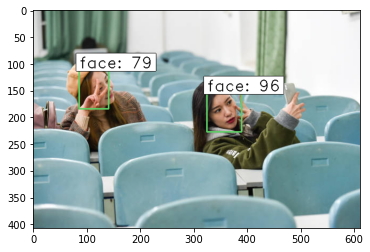

In [177]:
import matplotlib.pyplot as plt

filepath = os.path.join(img_path,'18201.jpg')
img = cv2.imread(filepath)
X, ratio = format_img(img, C)
X = np.transpose(X, (0, 2, 3, 1))
[Y1, Y2, F] = model_rpn.predict(X)
R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.7)
R[:, 2] -= R[:, 0]
R[:, 3] -= R[:, 1]
bboxes = {}
probs = {}
for jk in range(R.shape[0]//C.num_rois + 1):
  ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
  if ROIs.shape[1] == 0:
    break
  if jk == R.shape[0]//C.num_rois:
    curr_shape = ROIs.shape
    target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
    ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
    ROIs_padded[:, :curr_shape[1], :] = ROIs
    ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
    ROIs = ROIs_padded
  [P_cls, P_regr] = model_classifier.predict([F, ROIs])
  for ii in range(P_cls.shape[1]):
    if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
      continue
    cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]
    if cls_name not in bboxes:
      bboxes[cls_name] = []
      probs[cls_name] = []
    (x, y, w, h) = ROIs[0, ii, :]
    cls_num = np.argmax(P_cls[0, ii, :])
    try:
      (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
      tx /= C.classifier_regr_std[0]
      ty /= C.classifier_regr_std[1]
      tw /= C.classifier_regr_std[2]
      th /= C.classifier_regr_std[3]
      x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
    except:
      pass
    bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
    probs[cls_name].append(np.max(P_cls[0, ii, :]))
all_dets = []
for key in bboxes:
  bbox = np.array(bboxes[key])
  new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
  for jk in range(new_boxes.shape[0]):
    (x1, y1, x2, y2) = new_boxes[jk,:]
    (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)
    cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),2)
    textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
    all_dets.append((key,100*new_probs[jk]))
    (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
    textOrg = (real_x1, real_y1-0)
    cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
    cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
    cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)
print('Elapsed time = {}'.format(time.time() - st))
print(all_dets)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)